## This is the code to compute the mean TED for the collected data

In [ ]:
from nltk.parse.corenlp import CoreNLPServer
import os

# The server needs to know the location of the following files:
#   - stanford-corenlp-X.X.X.jar
#   - stanford-corenlp-X.X.X-models.jar
STANFORD = os.path.join("stanford_nlp", "stanford-corenlp-4.5.4")

# Create the server
server = CoreNLPServer(
   os.path.join(STANFORD, "stanford-corenlp-4.5.4.jar"),
   os.path.join(STANFORD, "stanford-corenlp-4.5.4-models.jar"),   
)

# Start the server in the background
server.start()

In [2]:
from nltk.parse.corenlp import CoreNLPParser

parser = CoreNLPParser()

In [11]:
def assign_children(root_node, root_parser):
    for child in root_parser:
        if not isinstance(child, str):
            child_node = Node(child.label())
            root_node.addkid(child_node)
            assign_children(child_node, child)
    return root_node

In [1]:
import pandas as pd

In [15]:
prompt_h = pd.read_csv('gpt_datasets/prompt_human.csv').dropna().reset_index(drop=True)
taboo_h = pd.read_csv('gpt_datasets/taboo_human.csv').dropna().reset_index(drop=True)
prompt_gpt = pd.read_csv('gpt_datasets/prompt_gpt.csv').dropna().reset_index(drop=True)
taboo_gpt = pd.read_csv('gpt_datasets/taboo_gpt.csv').dropna().reset_index(drop=True)
taboo_gpt_with_filt = pd.read_csv('gpt_datasets/taboo_gpt_with_filt.csv').dropna().reset_index(drop=True)

In [71]:
# Below is the example for prompt human

In [114]:
dct_intents_with_txts = {}
for index, row in prompt_h.iterrows():
    if row['intent'] in dct_intents_with_txts:
        dct_intents_with_txts[row['intent']].append(row['text'])
    else:
        dct_intents_with_txts[row['intent']] = [row['text']]

In [119]:
%%time

dct_parse_trees_from_stan = {}
dct_parse_trees_final = {}

for intent in dct_intents_with_txts.keys():
    lst_traverse = dct_intents_with_txts[intent]
    for idx, seed_txt in enumerate(lst_traverse):
        if seed_txt in dct_parse_trees_from_stan:
            parse_seed = dct_parse_trees_from_stan[seed_txt]
        else:
            parse_seed = next(parser.raw_parse(seed_txt))
            dct_parse_trees_from_stan[seed_txt] = parse_seed
        
        if seed_txt in dct_parse_trees_final:
            seed_tree = dct_parse_trees_final[seed_txt]
        else:
            seed_tree = Node(parse_seed.label())
            seed_tree = assign_children(seed_tree, parse_seed[0])
            dct_parse_trees_final[seed_txt] = seed_tree
            
server.stop()

Wall time: 1min 24s


In [120]:
dct_results_based_intent = {}

In [121]:
%%time

# NOTE: This runs a very long time (5-12h)!

for intent in dct_intents_with_txts.keys():
    if intent in dct_results_based_intent:
        continue
    res_lst = []
    lst_seed = dct_intents_with_txts[intent]
    lst_traverse = dct_intents_with_txts[intent]
    print(intent)
    
    for idx, seed_txt in enumerate(lst_seed):
        if idx % 200 == 0:
            print(idx)
            
        parse_seed = dct_parse_trees_from_stan[seed_txt]
        
        seed_tree = dct_parse_trees_final[seed_txt]

        idx_trav = idx + 1
        
        while (idx_trav < len(lst_traverse)):
            trav_txt = lst_traverse[idx_trav]
            
            # parse_trav = next(parser.raw_parse(trav_txt))
            
            parse_trav = dct_parse_trees_from_stan[trav_txt]
                
            trav_tree = dct_parse_trees_final[trav_txt]
            
#             trav_tree = Node(parse_trav.label())
#             trav_tree = assign_children(trav_tree, parse_trav[0])
            
            res = simple_distance(seed_tree, trav_tree)
            res_lst.append(res)
            
            idx_trav += 1
        
    dct_results_based_intent[intent] = res_lst

appointment
0
200
400
600
location
0
200
400
600
safe
0
200
400
withdrawal
0
200
400
balance
0
200
400
close
0
200
400
checks
0
200
400
hours
0
200
400
phone
0
200
400
routing
0
200
400
Wall time: 6h 22min 29s


In [7]:
import numpy as np
lst = []
for intent in dct_results_based_intent:
    lst.extend(dct_results_based_intent[intent])

In [11]:
arr = np.array(lst)

np.std(arr)

5.622339937017724

In [ ]:
np.mean(arr)
# repeat for multiple datasets, but again - the TED runs a long time

## Visualization

In [16]:
prompt_gpt = prompt_gpt.drop_duplicates('text')
taboo_h = taboo_h.drop_duplicates('text')
taboo_gpt = taboo_gpt.drop_duplicates('text')
prompt_h = prompt_h.drop_duplicates('text')
taboo_gpt_with_filt = taboo_gpt_with_filt.drop_duplicates('text')

In [34]:
prompt_h['text']=prompt_h['text'].apply(lambda x: x.lower())
taboo_h['text']=taboo_h['text'].apply(lambda x: x.lower())
prompt_gpt['text']=prompt_gpt['text'].apply(lambda x: x.lower())
taboo_gpt['text']=taboo_gpt['text'].apply(lambda x: x.lower())
taboo_gpt_with_filt['text']=taboo_gpt_with_filt['text'].apply(lambda x: x.lower())

In [35]:
import re
import string

prompt_h['text']=prompt_h['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
taboo_h['text']=taboo_h['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
prompt_gpt['text']=prompt_gpt['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
taboo_gpt['text']=taboo_gpt['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
taboo_gpt_with_filt['text']=taboo_gpt_with_filt['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [36]:
prompt_h['text']=prompt_h['text'].apply(lambda x: re.sub(' +',' ',x))
taboo_h['text']=taboo_h['text'].apply(lambda x: re.sub(' +',' ',x))
prompt_gpt['text']=prompt_gpt['text'].apply(lambda x: re.sub(' +',' ',x))
taboo_gpt['text']=taboo_gpt['text'].apply(lambda x: re.sub(' +',' ',x))
taboo_gpt_with_filt['text']=taboo_gpt_with_filt['text'].apply(lambda x: re.sub(' +',' ',x))

In [20]:
results = set()
taboo_h['text'].str.lower().str.split().apply(results.update)
print(len(results))

1487


In [37]:
results = set()
prompt_gpt['text'].str.lower().str.split().apply(results.update)
print(len(results))

1218


In [30]:
from wordcloud import STOPWORDS

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [29]:
text = " ".join(cat for cat in taboo_gpt.text)

In [31]:
# Generate word cloud
from wordcloud import WordCloud
path_ttf = 'open_sans/OpenSans-Regular.ttf'

word_cloud = WordCloud(
    width=1600,
    height=800,
    random_state=1,
    background_color="white",
    collocations=False,
    stopwords=STOPWORDS,
    ).generate(text)

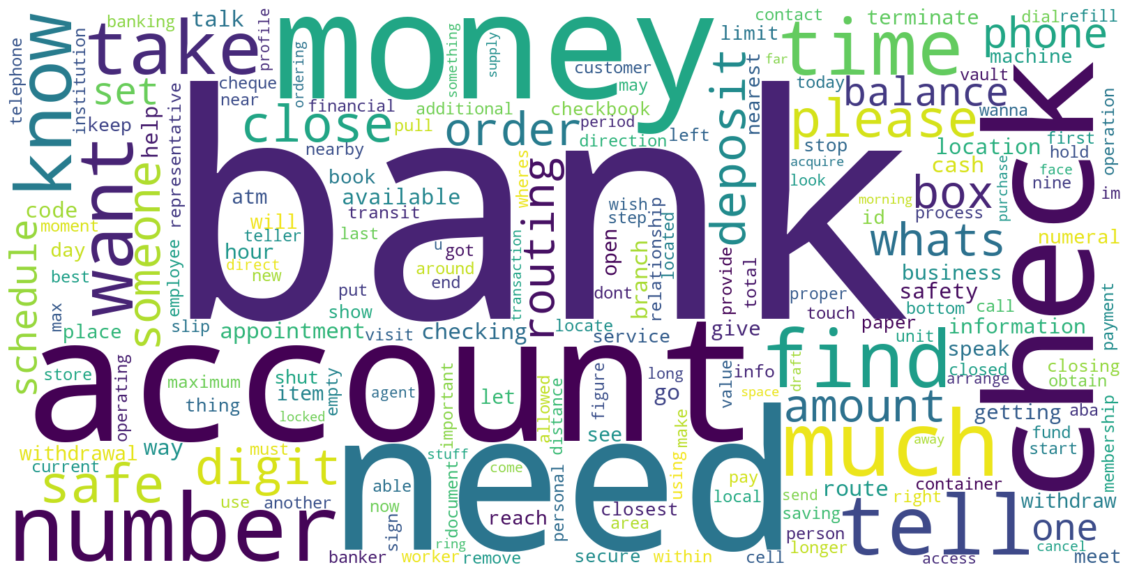

In [21]:
plt.figure(figsize=(20,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# TABOO 

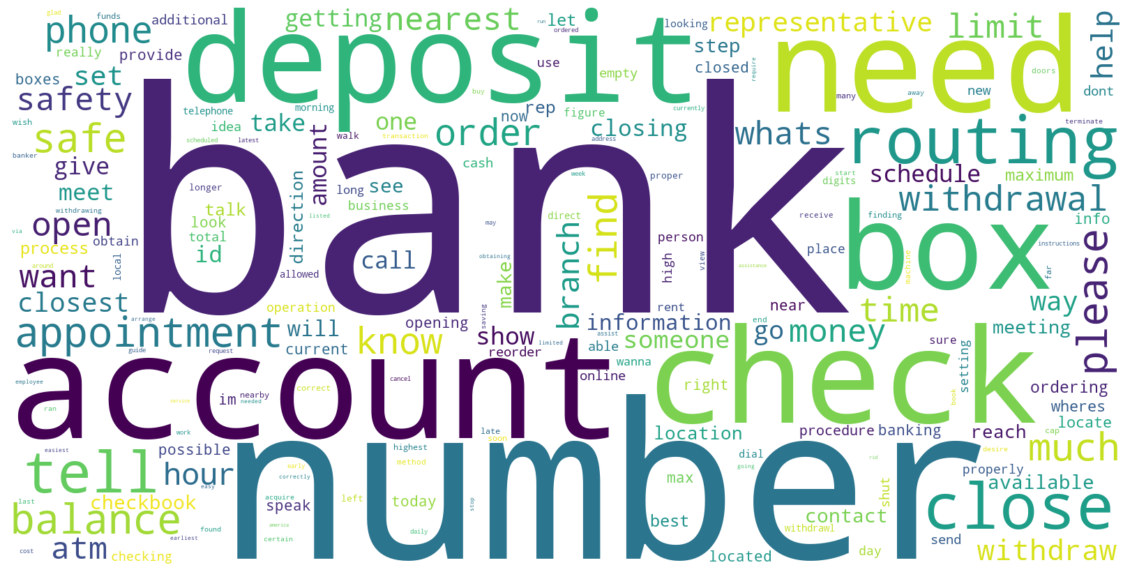

In [24]:
plt.figure(figsize=(20,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Prompt 

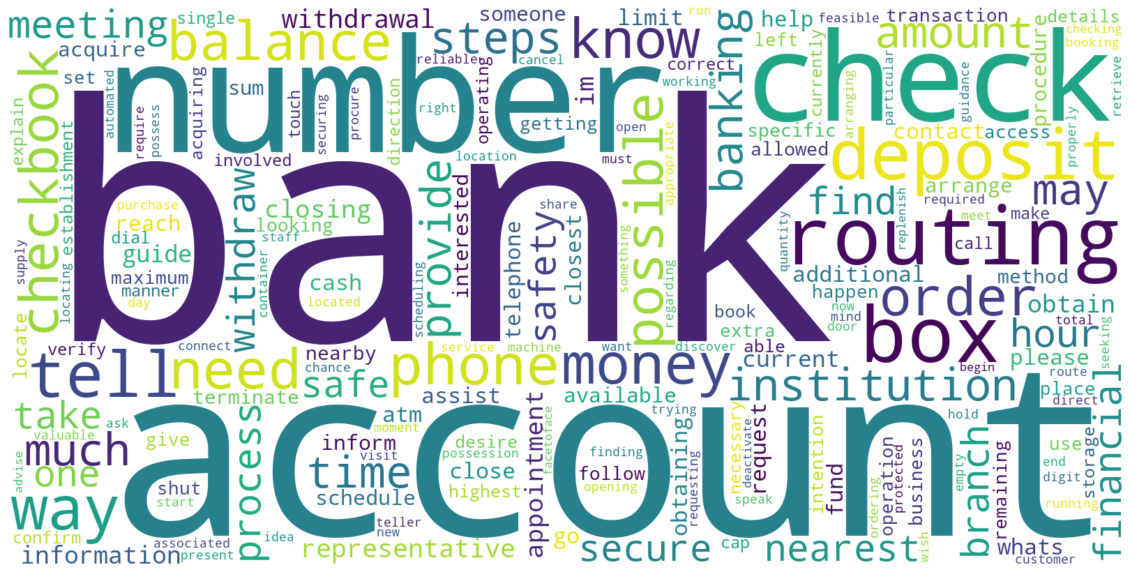

In [28]:
plt.figure(figsize=(20,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Prompt GPT

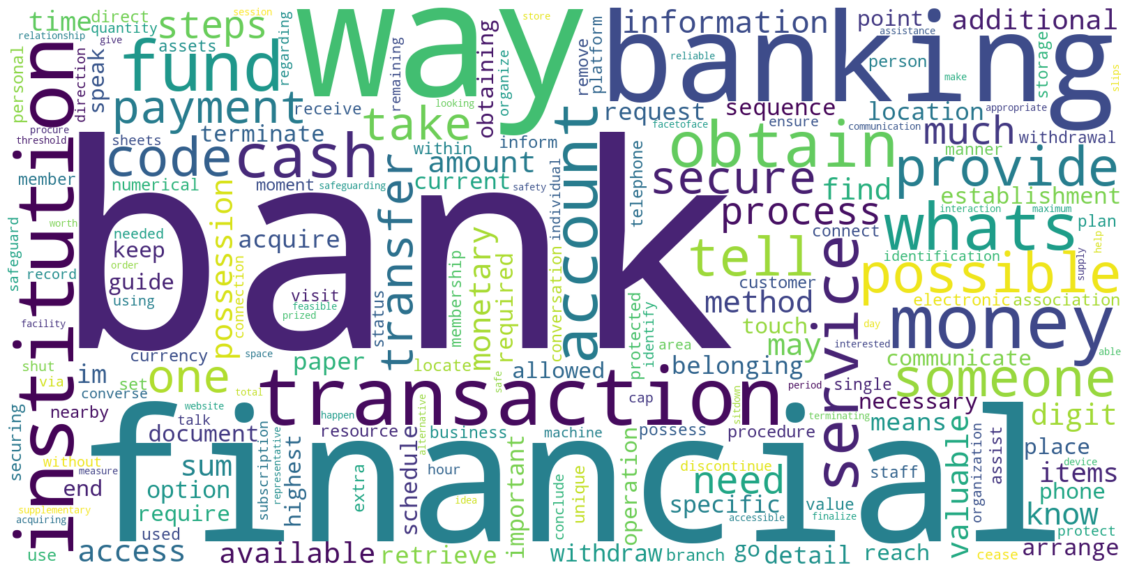

In [32]:
plt.figure(figsize=(20,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# TABOO GPT

In [34]:
import string
# word_count
same['word_count'] = same['text'].apply(lambda x: len(str(x).split()))
taboo['word_count'] = taboo['text'].apply(lambda x: len(str(x).split()))
same_gpt['word_count'] = same_gpt['text'].apply(lambda x: len(str(x).split()))
taboo_gpt['word_count'] = taboo_gpt['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
same['unique_word_count'] = same['text'].apply(lambda x: len(set(str(x).split())))
taboo['unique_word_count'] = taboo['text'].apply(lambda x: len(set(str(x).split())))
same_gpt['unique_word_count'] = same_gpt['text'].apply(lambda x: len(set(str(x).split())))
taboo_gpt['unique_word_count'] = taboo_gpt['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
same['stop_word_count'] = same['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
taboo['stop_word_count'] = taboo['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
same_gpt['stop_word_count'] = same_gpt['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
taboo_gpt['stop_word_count'] = taboo_gpt['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


# mean_word_length
same['mean_word_length'] = same['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
taboo['mean_word_length'] = taboo['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
same_gpt['mean_word_length'] = same_gpt['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
taboo_gpt['mean_word_length'] = taboo_gpt['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
same['char_count'] = same['text'].apply(lambda x: len(str(x)))
taboo['char_count'] = taboo['text'].apply(lambda x: len(str(x)))
same_gpt['char_count'] = same_gpt['text'].apply(lambda x: len(str(x)))
taboo_gpt['char_count'] = taboo_gpt['text'].apply(lambda x: len(str(x)))

# punctuation_count
same['punctuation_count'] = same['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
taboo['punctuation_count'] = taboo['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
same_gpt['punctuation_count'] = same_gpt['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
taboo_gpt['punctuation_count'] = taboo_gpt['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

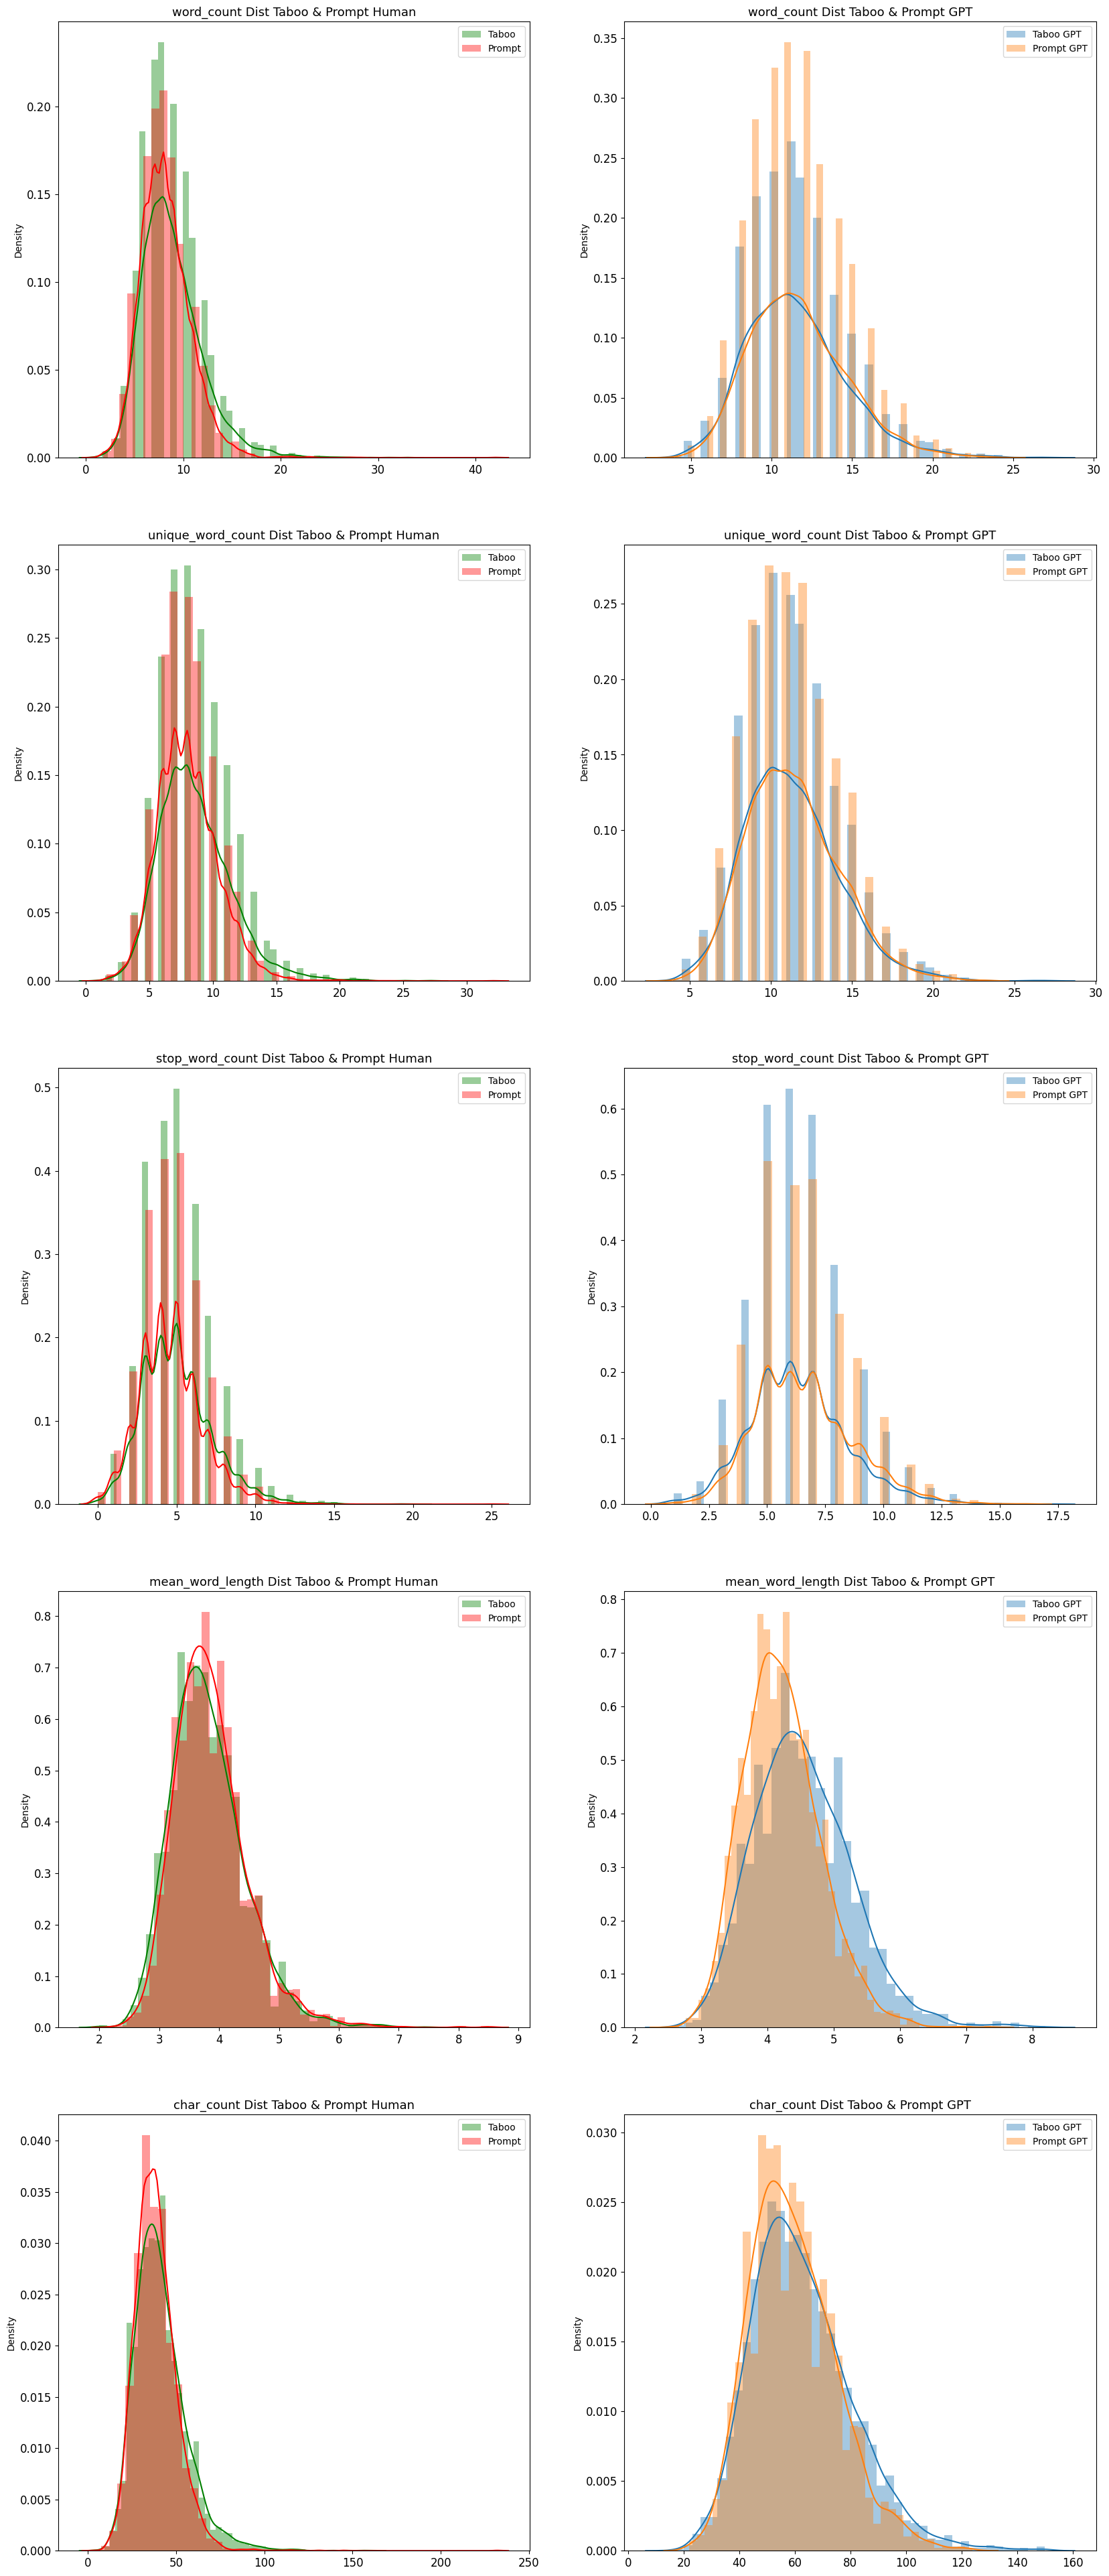

In [39]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count']

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(taboo[feature], label='Taboo', ax=axes[i][0], color='green')
    sns.distplot(same[feature], label='Prompt', ax=axes[i][0], color='red')

    sns.distplot(taboo_gpt[feature], label='Taboo GPT', ax=axes[i][1])
    sns.distplot(same_gpt[feature], label='Prompt GPT', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Dist Taboo & Prompt Human', fontsize=13)
    axes[i][1].set_title(f'{feature} Dist Taboo & Prompt GPT', fontsize=13)
    
    plt.savefig("output "+ str(i) +".png")

C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jance\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

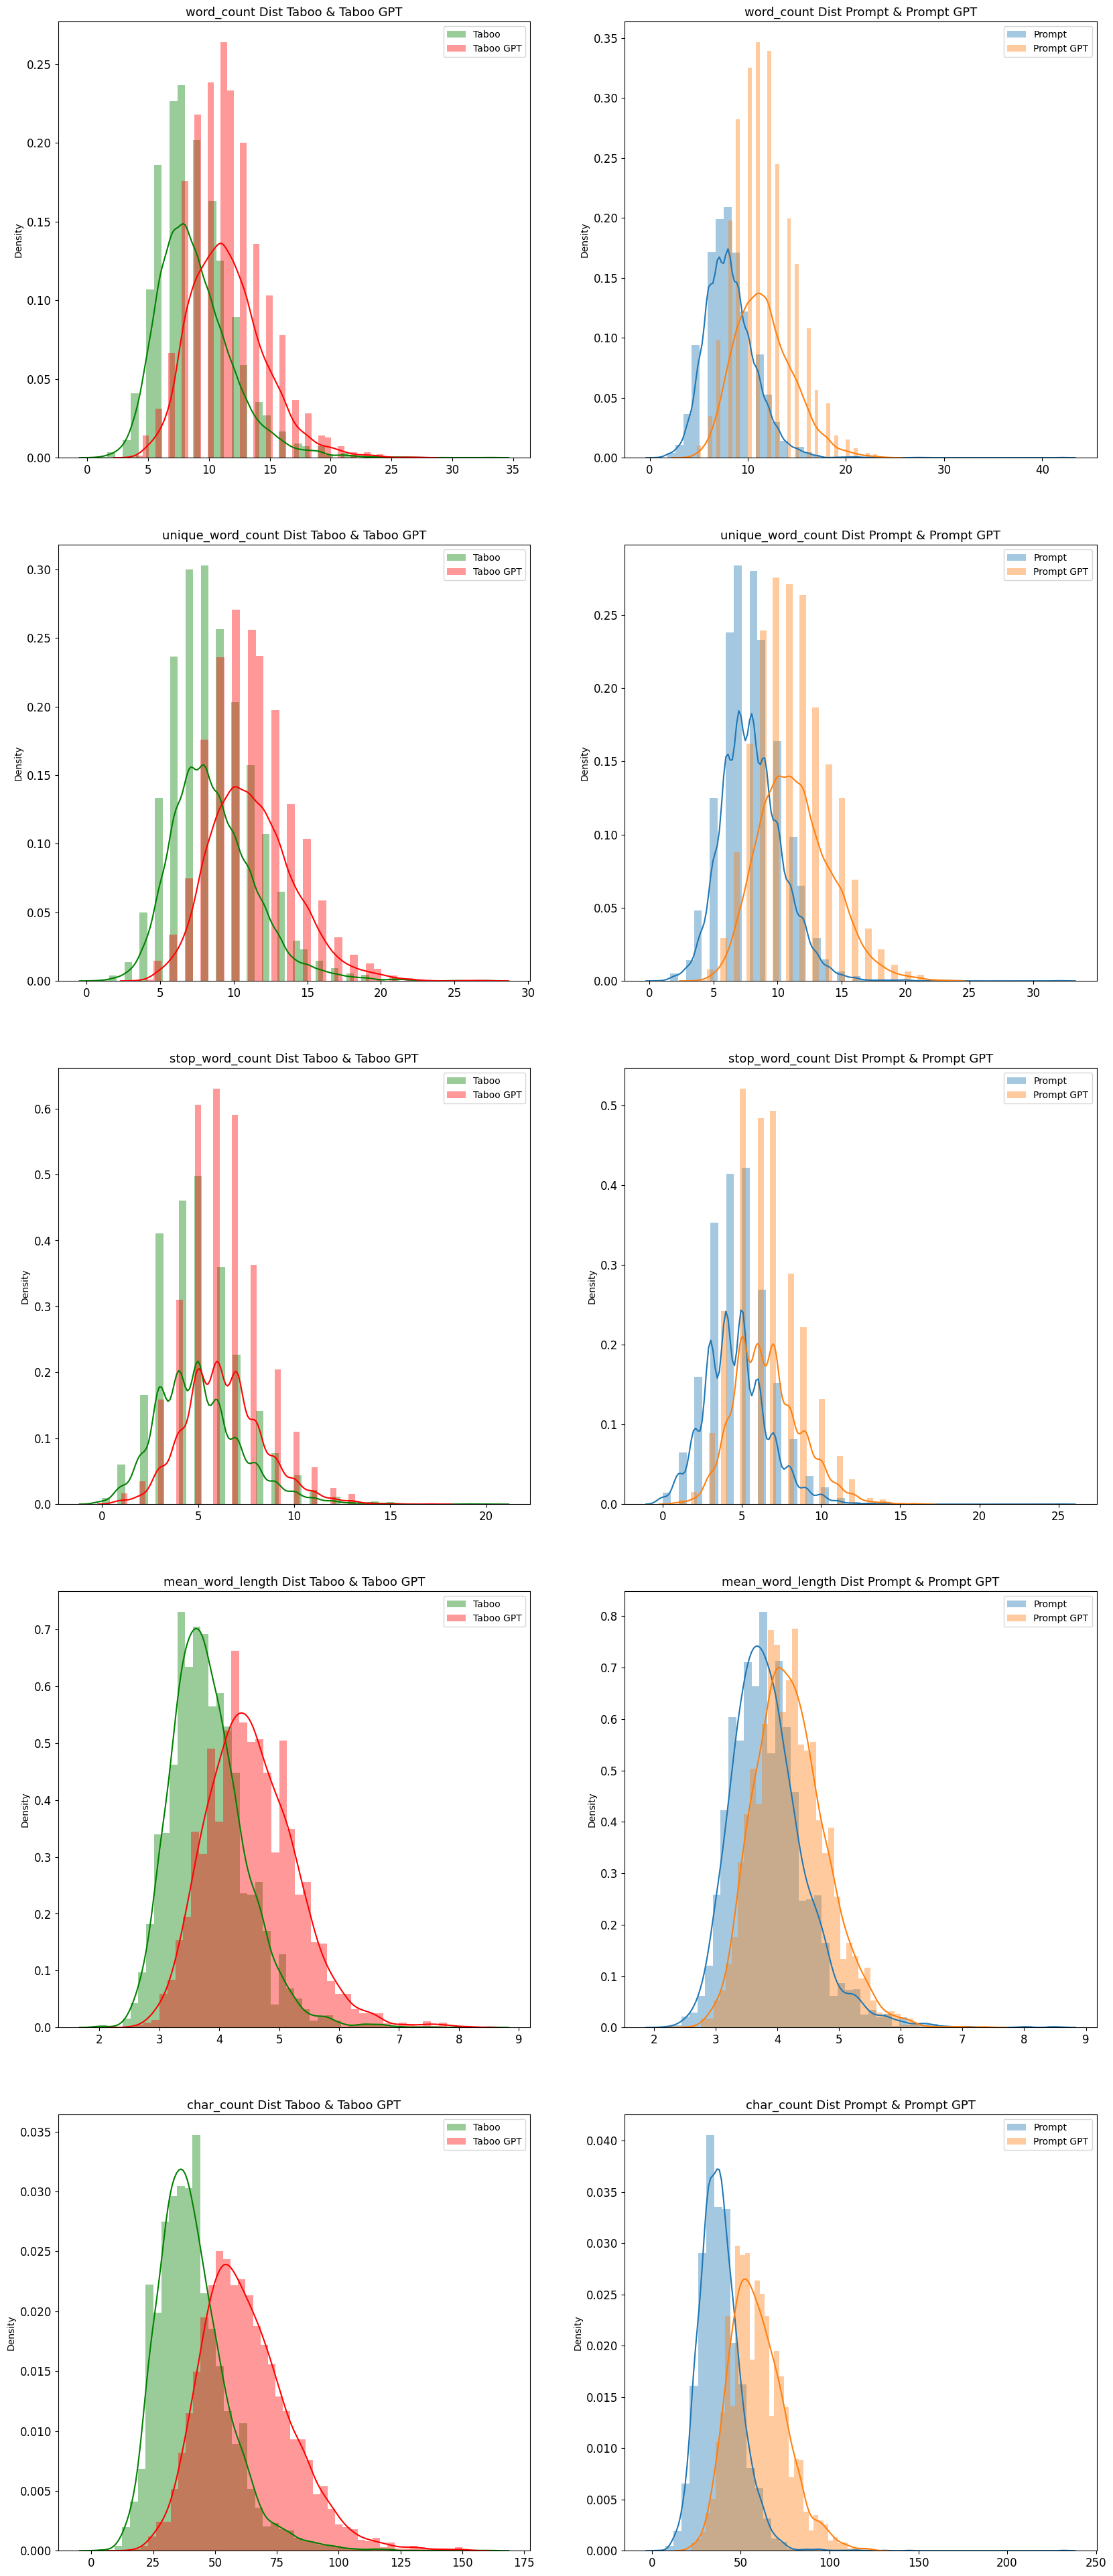

In [37]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count']

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(taboo[feature], label='Taboo', ax=axes[i][0], color='green')
    sns.distplot(taboo_gpt[feature], label='Taboo GPT', ax=axes[i][0], color='red')

    sns.distplot(same[feature], label='Prompt', ax=axes[i][1])
    sns.distplot(same_gpt[feature], label='Prompt GPT', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Dist Taboo & Taboo GPT', fontsize=13)
    axes[i][1].set_title(f'{feature} Dist Prompt & Prompt GPT', fontsize=13)

plt.show()